Exclude the records that SATIVA has highligted, redo the alignment and rebuild the tree.

In [1]:
from reprophylo import *

In [2]:
pj=Project('../fetch_clean_align_tree/target_locus.csv', pickle='amphib_post_SATIVA.pkl', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


In [3]:
pj.read_embl_genbank(['../fetch_clean_align_tree/12S_preSATIVA_amphib.gb'])

/home/reprophylo/reprophylo.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


In [4]:
pj.extract_by_locus()

Set the stage:

In [5]:
recs_to_keep = {'rrnS': []}
recs_to_drop = {'rrnS': []}

print "to drop: %s" %len(recs_to_drop['rrnS'])
print "to keep: %s" %len(recs_to_keep['rrnS'])

print "TOTAL: %s" %(len(recs_to_drop['rrnS']) + len(recs_to_keep['rrnS']))

to drop: 0
to keep: 0
TOTAL: 0


Record all record ids and assign them the status keep.

In [6]:
for r in pj.records_by_locus['rrnS']:
    recs_to_keep['rrnS'].append("_".join(r.id.split("_")[:-1]))

In [7]:
print "to drop: %s" %len(recs_to_drop['rrnS'])
print "to keep: %s" %len(recs_to_keep['rrnS'])

print "TOTAL: %s" %(len(recs_to_drop['rrnS']) + len(recs_to_keep['rrnS']))

to drop: 0
to keep: 203
TOTAL: 203


How many do we want to drop? Parse SATIVA output and extract records ids putatively mislabeled.

In [8]:
rec_mislabelled = {}
sativa=open('../SATIVA/12S.mis', 'r')

for line in sativa:
    if not line.startswith(";"):
        rec_mislabelled[line.split("\t")[0]] = line.split("\t")[4]


In [9]:
print len(rec_mislabelled)

5


Adjust lists accordingly.

In [10]:
for r in rec_mislabelled:
    print r
    if not r in recs_to_drop['rrnS']:
        print "\tadd to droplist"
        recs_to_drop['rrnS'].append(r)
    for i in reversed(range(len(recs_to_keep['rrnS']))):
#        print i
        if r in recs_to_keep['rrnS'][i]:
            print "\tremove from keeplist"
            del(recs_to_keep['rrnS'][i])

X95494.1
	add to droplist
	remove from keeplist
JN627424.1
	add to droplist
	remove from keeplist
HQ697272.1
	add to droplist
	remove from keeplist
AB023396.1
	add to droplist
	remove from keeplist
JN627425.1
	add to droplist
	remove from keeplist


In [11]:
print "to drop: %s" %len(recs_to_drop['rrnS'])
print "to keep: %s" %len(recs_to_keep['rrnS'])

print "TOTAL: %s" %(len(recs_to_drop['rrnS']) + len(recs_to_keep['rrnS']))

to drop: 5
to keep: 198
TOTAL: 203


Write out good records in full Genbank format including all metadata. Adjust to valid species and taxids before doing it.

Identify records with Subspecies.

In [12]:
from collections import defaultdict

Seqs = []
taxon_to_taxid = {}
recs_to_adjust = defaultdict(list)
taxon_to_recs = defaultdict(list)

for r in pj.records:
    if r.id in recs_to_keep['rrnS']:
        Seqs.append(r)
        
        source = [f for f in r.features if f.type == 'source'][0]

        #screen for subspecies and record taxids of valid species
        #if valid species record the taxid
        if (len(source.qualifiers['organism'][0].split(" ")) == 2):
            print source.qualifiers['organism'][0],
            if 'db_xref' in source.qualifiers:
#                print source.qualifiers['db_xref']
                for t in source.qualifiers['db_xref']:
#                    print t
                    if 'taxon' in t:
                        if not source.qualifiers['organism'][0] in taxon_to_taxid:
                            print " .. add to records"
                            taxon_to_taxid[source.qualifiers['organism'][0]] = t.split(":")[1]
                        else:
                            print " .. already covered"
                        taxon_to_recs[source.qualifiers['organism'][0]].append(r.id)
        #if the species status is 'sp.' but has a valid taxid
        elif (len(source.qualifiers['organism'][0].split(" ")) > 2 and source.qualifiers['organism'][0].split(" ")[1] == 'sp.'):
            print source.qualifiers['organism'][0],
            if 'db_xref' in source.qualifiers:
                for t in source.qualifiers['db_xref']:
                    if 'taxon' in t:
                        if not source.qualifiers['organism'][0] in taxon_to_taxid:
                            print " .. add to records"
                            taxon_to_taxid[source.qualifiers['organism'][0]] = t.split(":")[1]
                        else:
                            print " .. already covered" 
                        taxon_to_recs[source.qualifiers['organism'][0]].append(r.id)
        #all other cases we consider dubious, e.g. supspecies
        else:
            print "subspecies: %s" %source.qualifiers['organism'][0]
            recs_to_adjust[r.id] = []

subspecies: Alytes obstetricans pertinax
Pelophylax lessonae  .. add to records
Bombina bombina  .. add to records
Pelophylax ridibundus  .. add to records
Epidalea calamita  .. add to records
subspecies: Discoglossus pictus pictus
subspecies: Bombina variegata variegata
Rana temporaria  .. add to records
Xenopus laevis  .. add to records
subspecies: Bombina variegata scabra
Discoglossus pictus  .. add to records
Hyla arborea  .. add to records
subspecies: Bombina variegata variegata
Rana dalmatina  .. add to records
Rana temporaria  .. already covered
Pelophylax ridibundus  .. already covered
Bombina variegata  .. add to records
Rana catesbeiana  .. add to records
Xenopus laevis  .. already covered
subspecies: Salamandra salamandra alfredschmidti
subspecies: Bombina variegata scabra
subspecies: Discoglossus pictus auritus
Rana dalmatina  .. already covered
Rana temporaria  .. already covered
Hydromantes genei  .. add to records
Pelophylax lessonae  .. already covered
subspecies: Disco

Check if any of the taxa that were considered dubious are not already covered in the list after removing subspecies.

In [13]:
from collections import defaultdict

to_fetch = defaultdict(list)

for r in Seqs:
    if r.id in recs_to_adjust:
        source = [f for f in r.features if f.type == 'source'][0]
        adjust_from = source.qualifiers['organism'][0]
        adjust_to = " ".join(adjust_from.split(" ")[:2])
        print "%s -> %s" %(adjust_from,adjust_to)
        if adjust_to in taxon_to_taxid:
            taxon_to_recs[adjust_to].append(r.id)
            recs_to_adjust[r.id].append(adjust_to)
            recs_to_adjust[r.id].append(taxon_to_taxid[adjust_to])
        else:
            to_fetch[adjust_to].append(r.id)
            recs_to_adjust[r.id].append(adjust_to)

Alytes obstetricans pertinax -> Alytes obstetricans
Discoglossus pictus pictus -> Discoglossus pictus
Bombina variegata variegata -> Bombina variegata
Bombina variegata scabra -> Bombina variegata
Bombina variegata variegata -> Bombina variegata
Salamandra salamandra alfredschmidti -> Salamandra salamandra
Bombina variegata scabra -> Bombina variegata
Discoglossus pictus auritus -> Discoglossus pictus
Discoglossus pictus auritus -> Discoglossus pictus
Salamandra salamandra morenica -> Salamandra salamandra
Bombina variegata kolombatovici -> Bombina variegata
Lissotriton vulgaris meridionalis -> Lissotriton vulgaris
Salamandra salamandra bernardezi -> Salamandra salamandra
Alytes obstetricans boscai -> Alytes obstetricans
Alytes obstetricans boscai -> Alytes obstetricans
Alytes obstetricans almogavarii -> Alytes obstetricans
Discoglossus pictus auritus -> Discoglossus pictus
Discoglossus pictus auritus -> Discoglossus pictus
Salamandra salamandra almanzoris -> Salamandra salamandra
Sala

In [14]:
print len(to_fetch)

0


In [15]:
for r in Seqs:
    if r.id in recs_to_adjust:
        print "adjusting %s" %r.id
        source = r.features[0]
        print "%s\t->\t%s" %(source.qualifiers['organism'][0],recs_to_adjust[r.id][0])
        source = r.features[0]
        source.qualifiers['organism'] = [recs_to_adjust[r.id][0]]
        for i in range(len(source.qualifiers['db_xref'])):
            if 'taxon' in source.qualifiers['db_xref'][i]:
                source.qualifiers['db_xref'][i] = "taxon:"+recs_to_adjust[r.id][1]
        if not 'note' in source.qualifiers:
            source.qualifiers['note'] = ['modified from original record: adjusted to species']
        else:
            source.qualifiers['note'].append('modified from original record: adjusted to species')
#        print r.format('genbank')       
#    print r,recs_to_adjust[r]

adjusting AY585337.1
Alytes obstetricans pertinax	->	Alytes obstetricans
adjusting AY347451.1
Discoglossus pictus pictus	->	Discoglossus pictus
adjusting JX893174.1
Bombina variegata variegata	->	Bombina variegata
adjusting JX893176.1
Bombina variegata scabra	->	Bombina variegata
adjusting JX893175.1
Bombina variegata variegata	->	Bombina variegata
adjusting KF645375.1
Salamandra salamandra alfredschmidti	->	Salamandra salamandra
adjusting JX893178.1
Bombina variegata scabra	->	Bombina variegata
adjusting AY347456.1
Discoglossus pictus auritus	->	Discoglossus pictus
adjusting AY347452.1
Discoglossus pictus auritus	->	Discoglossus pictus
adjusting AY222458.1
Salamandra salamandra morenica	->	Salamandra salamandra
adjusting AY333653.1
Bombina variegata kolombatovici	->	Bombina variegata
adjusting AY147254.1
Lissotriton vulgaris meridionalis	->	Lissotriton vulgaris
adjusting DQ092285.1
Salamandra salamandra bernardezi	->	Salamandra salamandra
adjusting KJ858774.1
Alytes obstetricans bosca

Write only good records with all metadata in Genbank format.

In [16]:
from Bio import SeqIO
       
out = open('../12S_UKamphibians_SATIVA_cleaned.gb','w')
SeqIO.write(Seqs, out, "genbank")
out.close()

Exclude the records that were highlighted by SATIVA. Then realign and rebuild phylogeny.

In [17]:
pj.exclude(start_from_max=False, **recs_to_drop)

In [18]:
species=[]
for r in pj.records:
    if r.id in recs_to_keep['rrnS']:
        source = [f for f in r.features if f.type == 'source'][0]
        species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
    
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print sorted(species)

Total number of records: 198
Number of species (see below for full list): 23
['Alytes obstetricans', 'Bombina bombina', 'Bombina variegata', 'Bufo bufo', 'Chelydra serpentina', 'Cottus gobio', 'Discoglossus pictus', 'Epidalea calamita', 'Gallus gallus', 'Hydromantes genei', 'Hyla arborea', 'Ichthyosaura alpestris', 'Lissotriton helveticus', 'Lissotriton vulgaris', 'Pelophylax lessonae', 'Pelophylax ridibundus', 'Rana catesbeiana', 'Rana dalmatina', 'Rana temporaria', 'Salamandra salamandra', 'Triturus carnifex', 'Triturus cristatus', 'Xenopus laevis']


Write short 12S rRNA sequences (< 500bp) to fasta file to build new alignment outside Reprophylo later in script using hmmbuild. The Hidden Markov Model alignment will include all 12S rRNA sequences - short and long.

In [19]:
temp_seq = []

for r in pj.records_by_locus['rrnS']:
    if len(r.seq) < 500:
        temp_seq.append(r)
        
total = len(temp_seq)
print "Total number of records: %i" %total

from Bio import SeqIO

out=open('amphib_short_to_align_SATIVA.fasta','w')
SeqIO.write(temp_seq, out, 'fasta')
out.close()

Total number of records: 112


# Filter by Length

Write cropped records (minimum length of 500bp) to fasta and Genbank file.

In [20]:
from Bio import SeqIO

temp=[]
for r in pj.records:
    if len(r.seq) >= 500:
        temp.append(r)

out = open('amphib12S_cropped_500bp_SATIVA.gb', 'w')
SeqIO.write(temp, out, 'genbank')
out.close()

out = open('amphib12S_cropped_500bp_SATIVA.fa', 'w')
SeqIO.write(temp, out, 'fasta')
out.close()


del(temp)

Now view records in cropped genbank file.

In [21]:
for index, record in enumerate(SeqIO.parse("amphib12S_cropped_500bp_SATIVA.gb", "genbank")):
        print("index %i, ID = %s, length %i, with %i features"
          % (index, record.id, len(record.seq), len(record.features)))

index 0, ID = AY585337.1, length 937, with 2 features
index 1, ID = EU115993.1, length 933, with 2 features
index 2, ID = U52726.1, length 954, with 2 features
index 3, ID = JX893174.1, length 933, with 2 features
index 4, ID = AY581644.1, length 840, with 2 features
index 5, ID = JX893176.1, length 932, with 2 features
index 6, ID = JX893175.1, length 933, with 2 features
index 7, ID = KC977215.1, length 663, with 2 features
index 8, ID = AB761267.1, length 937, with 2 features
index 9, ID = AY581648.1, length 840, with 2 features
index 10, ID = JX893178.1, length 932, with 2 features
index 11, ID = KC977204.1, length 663, with 2 features
index 12, ID = HQ697272.1, length 924, with 2 features
index 13, ID = M10217.1, length 819, with 2 features
index 14, ID = KC977206.1, length 663, with 2 features
index 15, ID = EU880335.1, length 926, with 2 features
index 16, ID = DQ055835.1, length 936, with 2 features
index 17, ID = JN627424.1, length 930, with 2 features
index 18, ID = M27605.1,

Now need to filter all 12S rRNA sequences within pj.records dictionary by length to remove all sequences shorter than 500bp within Reprophylo.

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


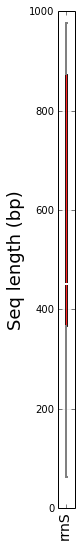

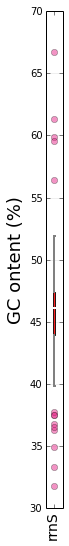

In [22]:
%matplotlib inline
pj.report_seq_stats()

In [23]:
# Define minima and maxima

gc_inliers = {
    'rrnS': [34,55]
}
len_inliers = {
    'rrnS': [500,1000]
}


# Apply to loci data
for locus in gc_inliers:
    # trim GC outliers
    pj.filter_by_gc_content(locus,
                            min_percent_gc=gc_inliers[locus][0],
                            max_percent_gc=gc_inliers[locus][1])

    # trim length outlier
    pj.filter_by_seq_length(locus,
                            min_length=len_inliers[locus][0],
                            max_length=len_inliers[locus][1])

Confirm that the length filter has worked.

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


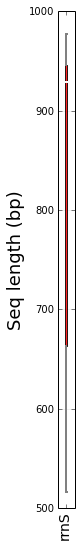

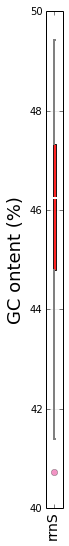

In [24]:
pj.report_seq_stats()

Pickle the project.

In [25]:
pickle_pj(pj, 'amphib_post_SATIVA.pkl')

'amphib_post_SATIVA.pkl'

# Long Alignment

Now, need to produce a sequence alignment file based on an alignment of all 12S sequences longer than 500bp. This will be done with the AlnConf class.

In [26]:
pj = unpickle_pj('amphib_post_SATIVA.pkl', git=False)

muscle default configuration:

In [27]:
muscle_default = AlnConf(pj,
                         method_name="muscleDefault-500bp-SATIVA",
                         program_name="muscle",
                         loci=['rrnS'])

muscle -in 750651477486369.36_rrnS.fasta


In [28]:
pj.align([muscle_default])

In [29]:
print pj.used_methods['muscleDefault-500bp-SATIVA']

AlnConf named muscleDefault-500bp-SATIVA with ID 750651477486369.36
Loci: rrnS 
Created on: Wed Oct 26 12:52:49 2016
Commands:
rrnS: muscle -in 750651477486369.36_rrnS.fasta

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: MUSCLE v3.8.31\nPal2Nal v14
 Program reference:\nEdgar 2004: MUSCLE: multiple sequence alignment with high accuracy and high throughput. Nucleic Acids Research 32(5):1792-1797\nMikita Suyama
 David Torrents
 and Peer Bork (2006) PAL2NAL: robust conversion of protein sequence alignments into the corresponding codon alignments.Nucleic Acids Res. 34
 W609-W612.
execution time:
14.8714580536


Core Methods section sentence:
The dataset(s) rrnS w

In [30]:
pj.alignments

{'rrnS@muscleDefault-500bp-SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (86 records of length 1291, IUPACProtein()) at 7f6affe6bb10>}

In [31]:
# record_id and source_organism are feature qualifiers in the SeqRecord object
files = pj.write_alns(id=['record_id','source_organism'],
                      format='fasta')
files

['rrnS@muscleDefault-500bp-SATIVA_aln.fasta']

Pickle the project.

In [32]:
pickle_pj(pj, 'amphib_post_SATIVA.pkl')

'amphib_post_SATIVA.pkl'

# Build tree from long alignment

Trim the alignment.

In [33]:
muscle_gappyout = TrimalConf(pj,                       # The Project

                            method_name='gappyout',  # Any unique string 
                                                     # ('gappyout' is default)
                            
                            program_name='trimal',   # No alternatives in 
                                                     # this ReproPhylo version
                            
                            cmd='default',           # the default is trimal. 
                                                     # Change it here
                                                     # or in pj.defaults['trimal']
                            
                            alns=['rrnS@muscleDefault-500bp-SATIVA'],  # 'all' by default
                            
                            trimal_commands={'gappyout': True} # By default, the gappyout algorithm is used.
                           )

trimal -in 536331477486453.01_rrnS@muscleDefault-500bp-SATIVA.fasta -gappyout


In [34]:
pj.trim([muscle_gappyout])

In [35]:
print pj.used_methods['gappyout']

TrimalConf named gappyout with ID 536331477486453.01
Alignments: rrnS@muscleDefault-500bp-SATIVA 
Created on: Wed Oct 26 12:54:13 2016
Commands:
rrnS@muscleDefault-500bp-SATIVA@gappyout: trimal -in 536331477486453.01_rrnS@muscleDefault-500bp-SATIVA.fasta -gappyout

Environment:Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: trimAl 1.2rev59
 Program reference: Salvador Capella-Gutierrez; Jose M. Silla-Martinez; Toni Gabaldon. trimAl: a tool for automated alignment trimming in large-scale phylogenetic analyses. Bioinformatics 2009 25: 1972-1973.
execution time:
0.859714984894

Core Methods section sentence:
The alignment(s) rrnS@muscleDefault-500bp-SATIVA were trimmed using 

In [36]:
pj.trimmed_alignments

{'rrnS@muscleDefault-500bp-SATIVA@gappyout': <<class 'Bio.Align.MultipleSeqAlignment'> instance (86 records of length 1182, IUPACAmbiguousDNA()) at 7f6affac5d50>}

In [37]:
files = pj.write_trimmed_alns(id=['record_id','source_organism'],
                                   format='fasta')
files

['rrnS@muscleDefault-500bp-SATIVA@gappyout_trimmed_aln.fasta']

Infer Maximum Likelihood tree based on the clipped alignment. We are going to use RAxML. Configure RAxML for trimmed muscle alignment.

In [38]:
raxml = RaxmlConf(pj, method_name='raxml-muscleDefault-500bp-SATIVA-trimmed',
                  program_name='raxmlHPC-PTHREADS-SSE3',
                  keepfiles=True,
                  cmd='raxmlHPC-PTHREADS-SSE3',
                  preset='fa',
                  alns=['rrnS@muscleDefault-500bp-SATIVA@gappyout'],
                  model='GAMMA',
                  threads=5,
                  cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 899801477486484.35_rrnS@muscleDefault-500bp-SATIVA@gappyout0 -p 619 -s 899801477486484.35_rrnS@muscleDefault-500bp-SATIVA@gappyout.fasta -T 5 -x 417 -N 100


Infer tree.

In [39]:
pj.tree([raxml])

In [40]:
print pj.used_methods['raxml-muscleDefault-500bp-SATIVA-trimmed']

RaxmlConf named raxml-muscleDefault-500bp-SATIVA-trimmed with ID 899801477486484.35
Alignments: rrnS@muscleDefault-500bp-SATIVA@gappyout 
Created on: Wed Oct 26 12:54:44 2016
Commands:
rrnS@muscleDefault-500bp-SATIVA@gappyout:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 899801477486484.35_rrnS@muscleDefault-500bp-SATIVA@gappyout0 -p 619 -s 899801477486484.35_rrnS@muscleDefault-500bp-SATIVA@gappyout.fasta -T 5 -x 417 -N 100

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.


In [41]:
pickle_pj(pj, 'amphib_post_SATIVA.pkl')

'amphib_post_SATIVA.pkl'

# Visualise Tree

Annotate final tree.

In [42]:
pj.add_qualifier_from_source('organism')

In [43]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [44]:
for species in ['Chelydra','Cottus','Gallus']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [45]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=None,
            html='muscleDefault-trimmed-amphib-raxml-post_SATIVA.html')

Create a static copy of the tree (the last *.png with the expected alignment id) for later.

In [46]:
%%bash

last_png=$(ls -hlrt *rrnS@muscleDefault-500bp-SATIVA@gappyout.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rrnS_muscleDefault_trimmed_amphib_500bp_SATIVA_raxml.png

Pickle the project.

In [47]:
pickle_pj(pj, 'amphib_post_SATIVA.pkl')

'amphib_post_SATIVA.pkl'

**=======================================================================================================**

In [48]:
from reprophylo import *

In [49]:
pj = unpickle_pj('amphib_post_SATIVA.pkl', git=False)

- Identify the record IDs of the sequences shorter than 500bp
- Write these sequences to new fasta file (make sure the sequence IDs are as Reprophylo expects them: 'id_f0')
- Prepare a hmm profile for the alignment the tree is built on (either muscle 'or mafft)

In [50]:
pj.alignments

{'rrnS@muscleDefault-500bp-SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (86 records of length 1291, IUPACProtein()) at 7f6afbc6c590>}

In [51]:
from Bio import AlignIO

out=open('500bp_amphib_align_SATIVA.fasta','w')

AlignIO.write(pj.fta('rrnS@muscleDefault-500bp-SATIVA'), out, 'fasta')

returning trimmed alignment object rrnS@muscleDefault-500bp-SATIVA@gappyout


1

Check number of records in file containing short 12S rRNA sequences.

In [53]:
from Bio import SeqIO

records = list(SeqIO.parse("amphib_short_to_align_SATIVA.fasta", "fasta"))
print("Total records: %i" % len(records))

Total records: 112


Check that record IDs are in format that reprophylo expects for alignment.

In [54]:
from Bio import SeqIO

short_seq = open("amphib_short_to_align_SATIVA.fasta", "rU")
sequences = []

for r in SeqIO.parse(short_seq, "fasta"):
    print(r.id)

AY322321.1_f0
FJ595208.1_f0
AY347451.1_f0
AF161036.1_f0
AJ440767.1_f0
KP109553.1_f0
KX269198.1_f0
AJ222711.1_f0
AY333688.1_f0
KF645375.1_f0
AY347456.1_f0
AY043038.1_f0
EU116959.1_f0
X95493.1_f0
AY347452.1_f0
AB023395.1_f0
AF218718.1_f0
AY333663.1_f0
AY222458.1_f0
KF664850.1_f0
AY333653.1_f0
KP109559.1_f0
KF645417.1_f0
AY333665.1_f0
AY147254.1_f0
KF645409.1_f0
AY147256.1_f0
U04702.1_f0
DQ092285.1_f0
KF645408.1_f0
AJ222710.1_f0
AY333669.1_f0
AY880481.1_f0
AY347457.1_f0
AY333687.1_f0
X86235.1_f0
AY347458.1_f0
DQ221219.1_f0
FJ595204.1_f0
KF645371.1_f0
AY333655.1_f0
AB023397.1_f0
AY333683.1_f0
U04704.1_f0
AY880461.1_f0
KP109558.1_f0
AY043041.1_f0
DQ092298.1_f0
KF645367.1_f0
DQ221215.1_f0
KF645365.1_f0
AY347455.1_f0
AY333684.1_f0
AY347454.1_f0
AY043034.1_f0
AJ440762.1_f0
FJ602097.1_f0
DQ092286.1_f0
AY333664.1_f0
AY043032.1_f0
KP109557.1_f0
KF645373.1_f0
KF645370.1_f0
AY333666.1_f0
AB159478.1_f0
KP109555.1_f0
DQ221220.1_f0
DQ221216.1_f0
AY347450.1_f0
AF124103.1_f0
AJ309142.1_f0
AY779191.1_f0


If record IDs were not in the format Reprophylo expects for tree construction, the code cells below could be used to format them to be 'id_f0'.

In [55]:
#temp_seq = []

#for r in pj.records:
    #if len(r.seq) < 500:
        #temp_seq.append(r)

#from Bio import SeqIO

#out=open('short_to_align.fasta','w')
#SeqIO.write(temp_seq, out, 'fasta')
#out.close()

In [56]:
#from Bio import SeqIO

#short_seq = open("short_to_align.fasta", "rU")
#sequences = []

#for r in SeqIO.parse(short_seq, "fasta"):
    #print(r.id)
    #r.description = r.id+'_f0'
    #r.id = r.description
    #print r.description
    #sequences.append(r)


#out = open("seq_to_align.fasta", "w")
#SeqIO.write(sequences, out, "fasta")
#out.close()

Check that sequences in reprophylo project have not been altered.

In [57]:
for r in pj.records:
    if len(r.seq) < 500:
        print r.id
        print r.description

AY322321.1
Rana lessonae 12S ribosomal RNA gene, partial sequence; tRNA-Val (trnV) gene, complete sequence; and 16S ribosomal RNA gene, partial sequence; mitochondrial genes for mitochondrial products.
FJ595208.1
Rana ridibunda 12S ribosomal RNA gene, partial sequence; mitochondrial.
AY347451.1
Discoglossus pictus pictus haplotype ph3 12S ribosomal RNA gene, partial sequence; mitochondrial.
AF161036.1
Rana temporaria 12S ribosomal RNA gene, partial sequence; mitochondrial gene for mitochondrial product.
AJ440767.1
Discoglossus pictus mitochondrion partial 12S rRNA gene.
KP109553.1
Hyla arborea isolate H523 12S ribosomal RNA gene, partial sequence; mitochondrial.
KX269198.1
Rana dalmatina isolate MSUZP-NPUA-R-21-1 12S ribosomal RNA gene, partial sequence; tRNA-Val gene, complete sequence; and 16S ribosomal RNA gene, partial sequence; mitochondrial.
AJ222711.1
Rana ridibunda mitochondrial 12S rRNA gene, isolated from Ashkhabad (Turkmenistan) and Uzbekistan.
AY333688.1
Bombina variegata i

Pickle the project.

In [58]:
pickle_pj(pj, 'amphib_post_SATIVA.pkl')

'amphib_post_SATIVA.pkl'

# Add short sequences to reference alignment

In [2]:
!hmmbuild 12S_amphib_ref_SATIVA.hmm 500bp_amphib_align_SATIVA.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.1b1 (May 2013); http://hmmer.org/
# Copyright (C) 2013 Howard Hughes Medical Institute.
# Freely distributed under the GNU General Public License (GPLv3).
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             500bp_amphib_align_SATIVA.fasta
# output HMM file:                  12S_amphib_ref_SATIVA.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen     W eff_nseq re/pos description
#---- -------------------- ----- ----- ----- ----- -------- ------ -----------
1     500bp_amphib_align_SATIVA    86  1182   943  1143     2.61  0.450 

# CPU time: 0.37u 0.00s 00:00:00.37 Elapsed: 00:00:00.38


Now use hmmalign to align the short 12S rRNA sequences to the longer reference alignment.

In [3]:
%%bash

hmmalign -o 12S_amphib500bpref_plus_short_query_SATIVA.sto \
--mapali 500bp_amphib_align_SATIVA.fasta \
12S_amphib_ref_SATIVA.hmm amphib_short_to_align_SATIVA.fasta

The hmmalign command has produced a file containing a new alignment of all 12S rRNA sequences (long and short) in stockholm output format. This must be converted to a more useful file format such as fasta or GenBank using the Seq command in BioPython.

In [4]:
from Bio import AlignIO

input_file = open("12S_amphib500bpref_plus_short_query_SATIVA.sto", "rU")
output_file = open("12S_AmphibAlign_ALL_SATIVA.fasta", "w")

alignment = AlignIO.read(input_file, "stockholm")
count = len(alignment)
AlignIO.write(alignment, output_file, "fasta")

output_file.close()
input_file.close()
print("Converted %i records" % count)

Converted 198 records


# Tree Building

The fasta file containing the 12S rRNA amphibian sequence alignment must now be converted into a format which can be used for alignment trimming. The alignment must be parsed to an alignment object, aln.

In [5]:
pj=unpickle_pj('amphib_post_SATIVA.pkl', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


In [6]:
from Bio import AlignIO
from Bio.Alphabet import generic_dna

aln = AlignIO.read(open("12S_amphib500bpref_plus_short_query_SATIVA.sto"), "stockholm", alphabet=generic_dna)
for r in aln:
    print(r.id + " is " + str(len(r)) + "bp")

AB188189.1_f0 is 1559bp
EF122793.1_f0 is 1559bp
JN860636.1_f0 is 1559bp
JN627421.1_f0 is 1559bp
JN627426.1_f0 is 1559bp
JN627422.1_f0 is 1559bp
KC977226.1_f0 is 1559bp
KC977215.1_f0 is 1559bp
AY326063.1_f0 is 1559bp
KC977206.1_f0 is 1559bp
KC977218.1_f0 is 1559bp
KC977222.1_f0 is 1559bp
KC977217.1_f0 is 1559bp
KC977220.1_f0 is 1559bp
KC977225.1_f0 is 1559bp
KC977204.1_f0 is 1559bp
AB685766.1_f0 is 1559bp
KC977224.1_f0 is 1559bp
KF049927.1_f0 is 1559bp
M57527.1_f0 is 1559bp
D12694.1_f0 is 1559bp
KU840522.1_f0 is 1559bp
AB761267.1_f0 is 1559bp
DQ055835.1_f0 is 1559bp
AY843601.1_f0 is 1559bp
AY325988.1_f0 is 1559bp
DQ158438.1_f0 is 1559bp
U52726.1_f0 is 1559bp
EU938400.1_f0 is 1559bp
EU880331.1_f0 is 1559bp
AY928619.1_f0 is 1559bp
EU880335.1_f0 is 1559bp
EU880336.1_f0 is 1559bp
EU880339.1_f0 is 1559bp
KF471517.1_f0 is 1559bp
EF373884.1_f0 is 1559bp
EF373885.1_f0 is 1559bp
EF373883.1_f0 is 1559bp
KP211422.1_f0 is 1559bp
EF373899.1_f0 is 1559bp
AP003321.1_f0 is 1559bp
FJ610338.1_f0 is 1559b

In [7]:
pj.alignments['rrnS@amphib_align_allseq_SATIVA'] = aln

In [8]:
pj.alignments

{'rrnS@amphib_align_allseq_SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (198 records of length 1559, DNAAlphabet()) at 7f3b048f3f50>,
 'rrnS@muscleDefault-500bp-SATIVA': <<class 'Bio.Align.MultipleSeqAlignment'> instance (86 records of length 1291, IUPACProtein()) at 7f3b04916790>}

In [9]:
pj.alignments.keys()

['rrnS@amphib_align_allseq_SATIVA', 'rrnS@muscleDefault-500bp-SATIVA']

Trim the alignment.

In [10]:
gappyout = TrimalConf(pj,                      # The Project

                      method_name='gappyout',  # Any unique string 
                                               # ('gappyout' is default)

                      program_name='trimal',   # No alternatives in 
                                               # this ReproPhylo version

                      cmd='default',           # the default is trimal. 
                                               # Change it here
                                               # or in pj.defaults['trimal']

                      alns=['rrnS@amphib_align_allseq_SATIVA'],# 'all' by default

                      trimal_commands={'gappyout': True} # By default, the gappyout algorithm is used.
                      )

trimal -in 506711477489096.71_rrnS@amphib_align_allseq_SATIVA.fasta -gappyout


In [11]:
pj.trim([gappyout])

In [12]:
print pj.used_methods['gappyout']

TrimalConf named gappyout with ID 506711477489096.71
Alignments: rrnS@amphib_align_allseq_SATIVA 
Created on: Wed Oct 26 13:38:16 2016
Commands:
rrnS@amphib_align_allseq_SATIVA@gappyout: trimal -in 506711477489096.71_rrnS@amphib_align_allseq_SATIVA.fasta -gappyout

Environment:Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: trimAl 1.2rev59
 Program reference: Salvador Capella-Gutierrez; Jose M. Silla-Martinez; Toni Gabaldon. trimAl: a tool for automated alignment trimming in large-scale phylogenetic analyses. Bioinformatics 2009 25: 1972-1973.
execution time:
1.96037101746

Core Methods section sentence:
The alignment(s) rrnS@amphib_align_allseq_SATIVA were trimmed using t

In [13]:
pj.trimmed_alignments

{'rrnS@amphib_align_allseq_SATIVA@gappyout': <<class 'Bio.Align.MultipleSeqAlignment'> instance (198 records of length 1189, IUPACAmbiguousDNA()) at 7f3b04e9ec90>,
 'rrnS@muscleDefault-500bp-SATIVA@gappyout': <<class 'Bio.Align.MultipleSeqAlignment'> instance (86 records of length 1182, IUPACAmbiguousDNA()) at 7f3b054f39d0>}

In [14]:
files = pj.write_trimmed_alns(id=['record_id','source_organism'],
                                   format='fasta')
files

['rrnS@muscleDefault-500bp-SATIVA@gappyout_trimmed_aln.fasta',
 'rrnS@amphib_align_allseq_SATIVA@gappyout_trimmed_aln.fasta']

Infer Maximum Likelihood tree based on the clipped alignment. We are going to use RAxML.

Configure RAxML.

In [15]:
raxml = RaxmlConf(pj, method_name='raxml-muscleDefault-trimmed',
                  program_name='raxmlHPC-PTHREADS-SSE3',
                  keepfiles=True,
                  cmd='raxmlHPC-PTHREADS-SSE3',
                  preset='fa',
                  alns=['rrnS@amphib_align_allseq_SATIVA@gappyout'],
                  model='GAMMA',
                  threads=5,
                  cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 280851477489120.51_rrnS@amphib_align_allseq_SATIVA@gappyout0 -p 987 -s 280851477489120.51_rrnS@amphib_align_allseq_SATIVA@gappyout.fasta -T 5 -x 315 -N 100


In [16]:
pj.tree([raxml])

In [17]:
print pj.used_methods['raxml-muscleDefault-trimmed']

RaxmlConf named raxml-muscleDefault-trimmed with ID 280851477489120.51
Alignments: rrnS@amphib_align_allseq_SATIVA@gappyout 
Created on: Wed Oct 26 13:38:40 2016
Commands:
rrnS@amphib_align_allseq_SATIVA@gappyout:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 280851477489120.51_rrnS@amphib_align_allseq_SATIVA@gappyout0 -p 987 -s 280851477489120.51_rrnS@amphib_align_allseq_SATIVA@gappyout.fasta -T 5 -x 315 -N 100

Environment:
Platform: Linux-4.4.0-38-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc4
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.
execution tim

In [18]:
pj.trees.keys()

['rrnS@muscleDefault-500bp-SATIVA@gappyout@raxml-muscleDefault-500bp-SATIVA-trimmed',
 'rrnS@amphib_align_allseq_SATIVA@gappyout@raxml-muscleDefault-trimmed']

Pickle the project.

In [19]:
pickle_pj(pj, 'amphib_post_SATIVA.pkl')

'amphib_post_SATIVA.pkl'

# Visualise tree

Now let's visualize the tree containing all 12S rRNA sequences with outliers identified by SATIVA removed.

- Prepare tree annotation:
- define outgroups
- specify support coloration

In [20]:
pj.add_qualifier_from_source('organism')

In [21]:
for species in ['Chelydra','Cottus','Gallus']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [22]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [23]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='muscleDefault-trimmed-amphib-all-SATIVA-raxml.html')

Create a static copy of the tree (the last *.png with the expected alignment id) for later.

In [24]:
%%bash

last_png=$(ls -hlrt *rrnS@amphib_align_allseq_SATIVA@gappyout.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rrnS_muscleDefault-trimmed-amphib-all-SATIVA-raxml.png

Pickle the project.

In [25]:
pickle_pj(pj, 'amphib_post_SATIVA.pkl')

'amphib_post_SATIVA.pkl'

Write out alignment for pplacer input. Need to modify record id - remove the '_f0' that is appended by Reprophylo.

In [26]:
from Bio import AlignIO

aln = pj.fta('rrnS@amphib_align_allseq_SATIVA@gappyout')

for r in aln:
    r.id = "_".join(r.id.split("_")[:-1])
    r.description = r.id
    
out=open('../12S_UKamphibians_SATIVA_cleaned.alignment.fasta', 'w')
AlignIO.write(aln, out, 'fasta')
out.close()

out=open('../12S_UKamphibians_SATIVA_cleaned.alignment.phylip', 'w')
AlignIO.write(aln, out, 'phylip-relaxed')
out.close()

returning trimmed alignment object rrnS@amphib_align_allseq_SATIVA@gappyout
